# UPSTREAM ANALYSIS FOR SPATIAL TRANSCRIPTOMICS

## IMPORT PACKAGES

In [17]:
import argparse
import json
import pandas as pd
import scanpy as sc
import scanorama
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from anndata import AnnData
from matplotlib.image import imread
from pathlib import Path
from scanpy import read_10x_h5
from typing import Union, Optional

## Read SpaceRanger output to AnnData

In [37]:
# Define a function to read to AnnData
def read_visium_mtx(
    path: Union[str, Path],
    *,
    load_images: bool = True,
    library_id: Optional[str] = None,
) -> AnnData:
    """\
    Read 10x-Genomics-formatted visum dataset.
    In addition to reading regular 10x output,
    this looks for the `spatial` folder and loads images,
    coordinates and scale factors.
    Based on the `Space Ranger output docs`_.
    See :func:`~scanpy.pl.spatial` for a compatible plotting function.
    .. _Space Ranger output docs: https://support.10xgenomics.com/spatial-gene-expression/software/pipelines/latest/output/overview
    Parameters
    ----------
    path
        Path to a spaceranger output directory
    load_images:
        Whether or not to load images
    library_id
        Identifier for the visium library. Can be modified when concatenating multiple adata objects.

    Returns
    -------
    Annotated data matrix, where observations/cells are named by their
    barcode and variables/genes by gene name. Stores the following information:
    :attr:`~anndata.AnnData.X`
        The data matrix is stored
    :attr:`~anndata.AnnData.obs_names`
        Cell names
    :attr:`~anndata.AnnData.var_names`
        Gene names
    :attr:`~anndata.AnnData.var`\\ `['gene_ids']`
        Gene IDs
    :attr:`~anndata.AnnData.var`\\ `['feature_types']`
        Feature types
    :attr:`~anndata.AnnData.uns`\\ `['spatial']`
        Dict of spaceranger output files with 'library_id' as key
    :attr:`~anndata.AnnData.uns`\\ `['spatial'][library_id]['images']`
        Dict of images (`'hires'` and `'lowres'`)
    :attr:`~anndata.AnnData.uns`\\ `['spatial'][library_id]['scalefactors']`
        Scale factors for the spots
    :attr:`~anndata.AnnData.uns`\\ `['spatial'][library_id]['metadata']`
        Files metadata: 'chemistry_description', 'software_version', 'source_image_path'
    :attr:`~anndata.AnnData.obsm`\\ `['spatial']`
        Spatial spot coordinates, usable as `basis` by :func:`~scanpy.pl.embedding`.
    """

    path = Path(path)
    adata = read_10x_h5(path / "filtered_feature_bc_matrix.h5")
    # use ensemble IDs as index, because they are unique
    adata.var["gene_symbol"] = adata.var_names
    adata.var.set_index("gene_ids", inplace=True)

    adata.uns["spatial"] = dict()

    if library_id is None:
        library_id = "library_id"

    adata.uns["spatial"][library_id] = dict()

    if load_images:
        files = dict(
            tissue_positions_file=path / "spatial/tissue_positions.csv",
            scalefactors_json_file=path / "spatial/scalefactors_json.json",
            hires_image=path / "spatial/tissue_hires_image.png",
            lowres_image=path / "spatial/tissue_lowres_image.png",
        )

        # Check if files exist; continue if images are missing
        for f in files.values():
            if not f.exists():
                if any(x in str(f) for x in ["hires_image", "lowres_image"]):
                    print("You seem to be missing an image file.")
                    print("Could not find '{f}'.")
                else:
                    raise OSError(f"Could not find '{f}'")

        # Check for existance of images
        adata.uns["spatial"][library_id]["images"] = dict()
        for res in ["hires", "lowres"]:
            try:
                adata.uns["spatial"][library_id]["images"][res] = imread(str(files[f"{res}_image"]))
            except Exception:
                raise OSError(f"Could not find '{res}_image'")

        # Read JSON scale factors
        adata.uns["spatial"][library_id]["scalefactors"] = json.loads(files["scalefactors_json_file"].read_bytes())
        adata.uns["spatial"][library_id]["metadata"] = {k: "NA" for k in ("chemistry_description", "software_version")}

        # Read coordinates
        positions = pd.read_csv(files["tissue_positions_file"], index_col="barcode", dtype={"in_tissue": bool})
        adata.obs = adata.obs.join(positions, how="left")
        adata.obsm["spatial"] = adata.obs[["pxl_col_in_fullres", "pxl_row_in_fullres"]].to_numpy()
        adata.obs.drop(
            columns=["pxl_row_in_fullres", "pxl_col_in_fullres"],
            inplace=True,
        )

    return adata


#if __name__ == "__main__":
    # Parse command-line arguments
    parser = argparse.ArgumentParser(
        description="Load spatial transcriptomics data from MTX matrices and aligned images."
    )
    parser.add_argument(
        "--SRCountDir", metavar="SRCountDir", type=str, default=None, help="Input directory with Spaceranger data."
    )
    parser.add_argument("--outAnnData", metavar="outAnnData", type=str, default=None, help="Output h5ad file path.")
    args = parser.parse_args()

    # Read Visium data
    st_adata = read_visium_mtx(args.SRCountDir, library_id=None, load_images=True)

    # Write raw anndata to file
    st_adata.write(args.outAnnData)

In [39]:
# Path
path_visium="/mnt/rdisk/duydao/scRNAseq/Spatial_transcriptomics/spaceranger_tutorial/output/Visium_FFPE_Mouse_Brain/outs"
h5ad_file="/mnt/rdisk/duydao/scRNAseq/Spatial_transcriptomics/spaceranger_tutorial/output/Visium_FFPE_Mouse_Brain/outs/filtered_feature_bc_matrix.h5"
image="/mnt/rdisk/duydao/scRNAseq/Spatial_transcriptomics/spaceranger_tutorial/output/Visium_FFPE_Mouse_Brain/outs/spatial/tissue_hires_image.png"

# Read Visium data
adata = read_visium_mtx(path_visium,
                load_images=True,
                library_id="Visium_FFPE_Mouse_Brain")

/opt/miniconda/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/miniconda/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [40]:
# Make variable names unique
adata.var_names_make_unique()

## QUALITY CHECK

In [41]:
import re

#Add info on mitochondrial and hemoglobin genes to the objects.
adata.var['mt'] = adata.var['gene_symbol'].str.contains("mt", flags=re.IGNORECASE)
adata.var['hb'] = adata.var['gene_symbol'].str.contains("hb", flags=re.IGNORECASE)

#Calculate quality control matrix
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','hb'], percent_top=None, log1p=False, inplace=True)

Perform some basic filtering of spots based on total counts and expressed genes.

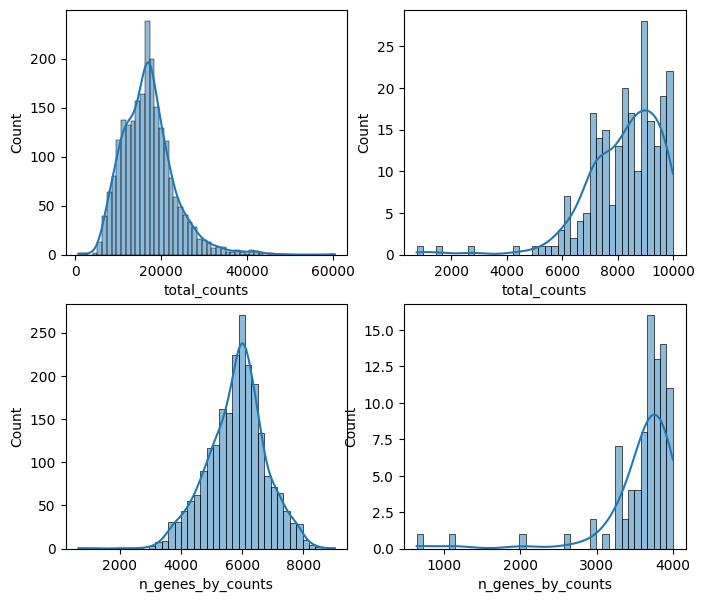

In [42]:
fig, axs = plt.subplots(2,2,figsize=(8,7))
p=sns.histplot(adata.obs["total_counts"], kde=True, ax=axs[0,0])
p=sns.histplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=True, bins=40, ax=axs[0,1])
p=sns.histplot(adata.obs["n_genes_by_counts"], kde=True, bins=40, ax=axs[1,0])
p=sns.histplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000], kde=True, bins=40)

In [ ]:
# Remove spots outside tissue
adata = adata[adata.obs["in_tissue"] == 1]

##Filter cell outliers based on counts and numbers of genes expressed.
sc.pp.filter_cells(adata, min_counts=500) ## Min spot
#sc.pp.filter_cells(adata, max_counts=)
sc.pp.filter_cells(adata, min_genes=250) ## Min genes per spot
print("Filtered out spots outside tissue:", adata.shape)




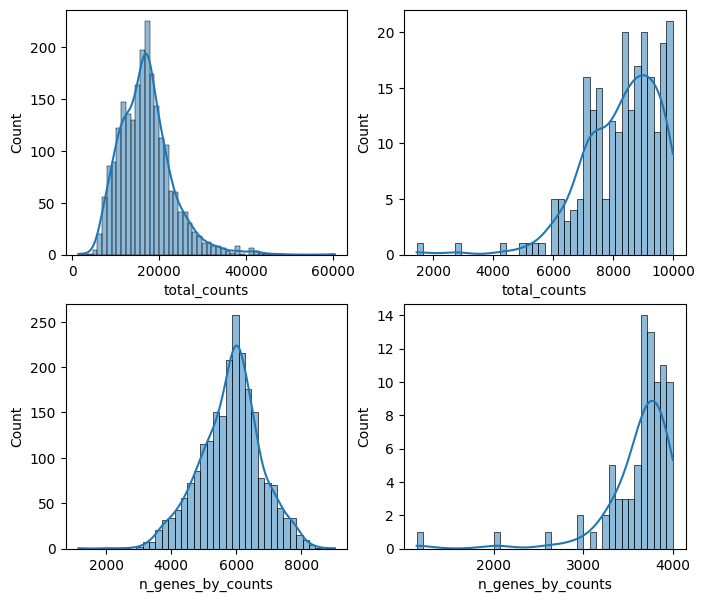

In [80]:
fig, axs = plt.subplots(2,2,figsize=(8,7))
p=sns.histplot(adata.obs["total_counts"], kde=True, ax=axs[0,0])
p=sns.histplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=True, bins=40, ax=axs[0,1])
p=sns.histplot(adata.obs["n_genes_by_counts"], kde=True, bins=40, ax=axs[1,0])
p=sns.histplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000], kde=True, bins=40)

In [81]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)


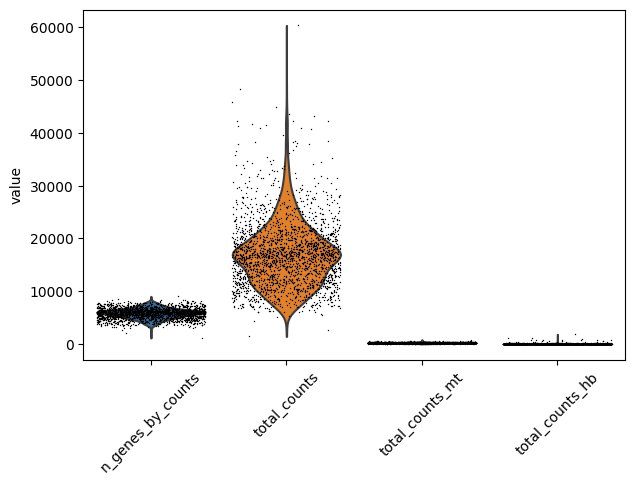

In [82]:
#Violin plot for the count
sc.pl.violin(adata, keys=['n_genes_by_counts', 'total_counts', 'total_counts_mt', 'total_counts_hb'],
             jitter=0.4, rotation= 45)

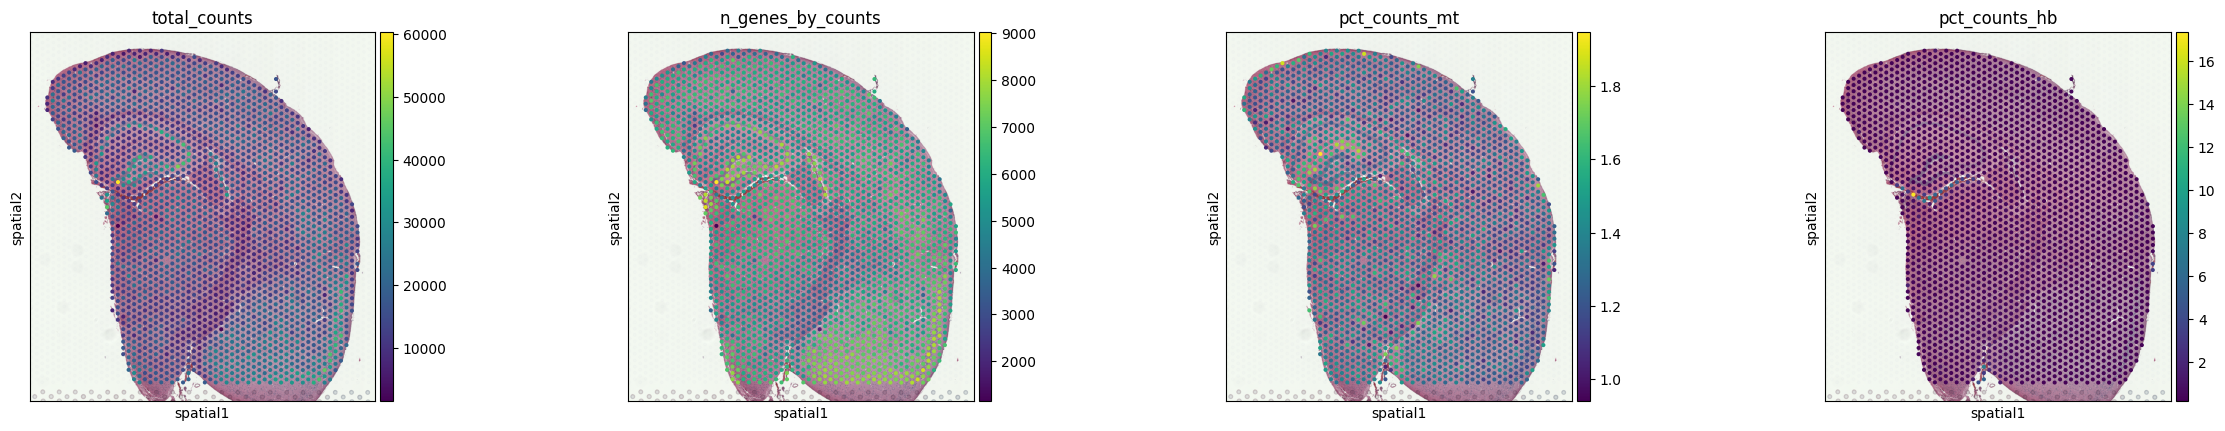

In [83]:
#
sc.pl.spatial(adata, color = ["total_counts", "n_genes_by_counts",'pct_counts_mt', 'pct_counts_hb'])

In [84]:
keep = (adata.obs['pct_counts_hb'] < 20) & (adata.obs['pct_counts_mt'] < 25) & (adata.obs['n_genes_by_counts'] > 1000)
print(sum(keep))

adata = adata[keep,:]
print(f"#cells after MT filter: {adata.n_obs}")


2260
#cells after MT filter: 2260


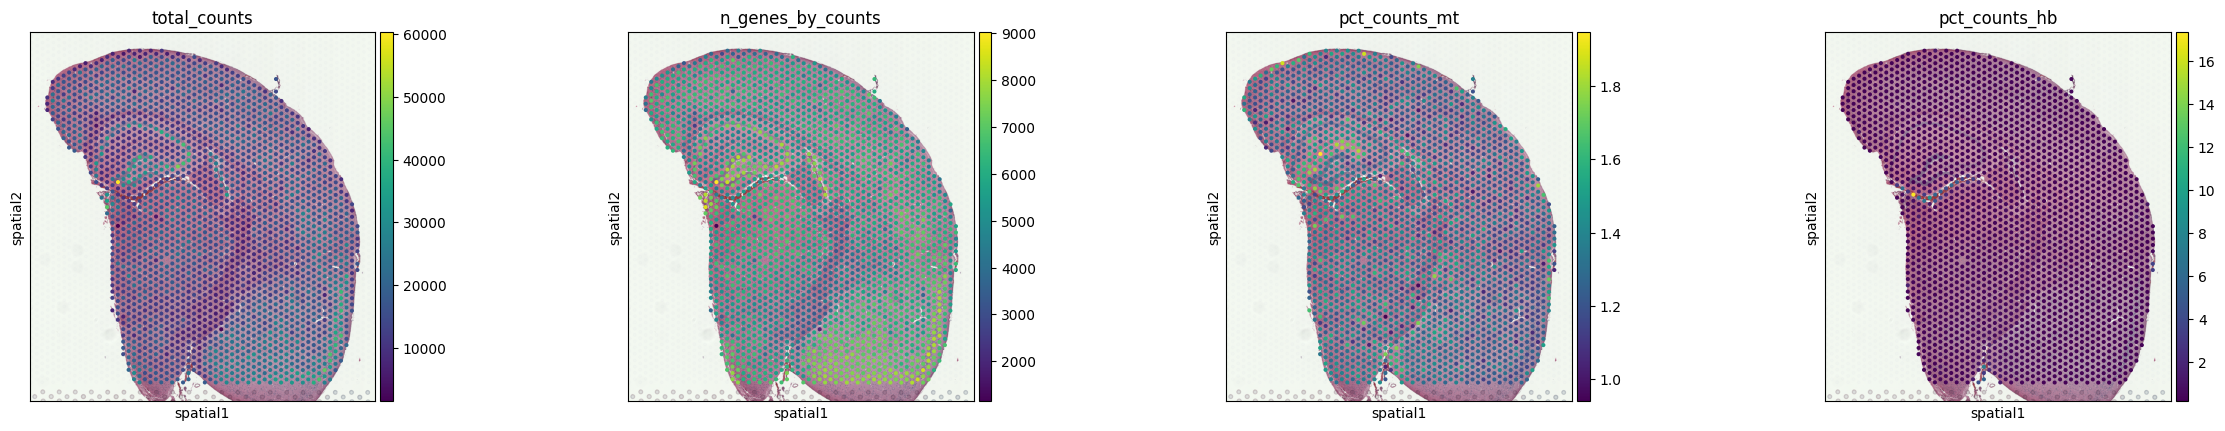

In [85]:
sc.pl.spatial(adata, 
              color = ["total_counts", "n_genes_by_counts",'pct_counts_mt', 'pct_counts_hb'])

/opt/miniconda/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


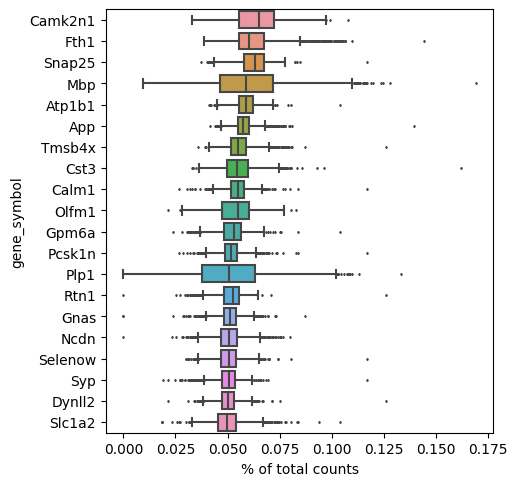

In [86]:
# Extract & plot top 20 highly expressed genes
sc.pl.highest_expr_genes(adata, n_top=20, gene_symbols='gene_symbol')

In [77]:
import numpy as np

# Extract the mitochondrial genes and hemoglobin genes.
mito_genes = adata.var['gene_symbol'].str.contains("mt", flags=re.IGNORECASE)
hb_genes = adata.var['gene_symbol'].str.contains("hb", flags=re.IGNORECASE)


remove = np.add(mito_genes, hb_genes)
remove[adata.var_names == "Bc1"] = True
keep = np.invert(remove)
print("Total removal: ", sum(remove))

adata = adata[:,keep]

print(adata.n_obs, adata.n_vars)

Total removal:  0
2260 19166


In [78]:
# save the counts to a separate object for later, we need the normalized counts in raw for DEG dete
counts_adata = adata.copy()

sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

# take 1500 variable genes per batch and then use the union of them.
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=1500, inplace=True)

# subset for variable genes
adata.raw = adata

# scale data
sc.pp.scale(adata)

/opt/miniconda/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


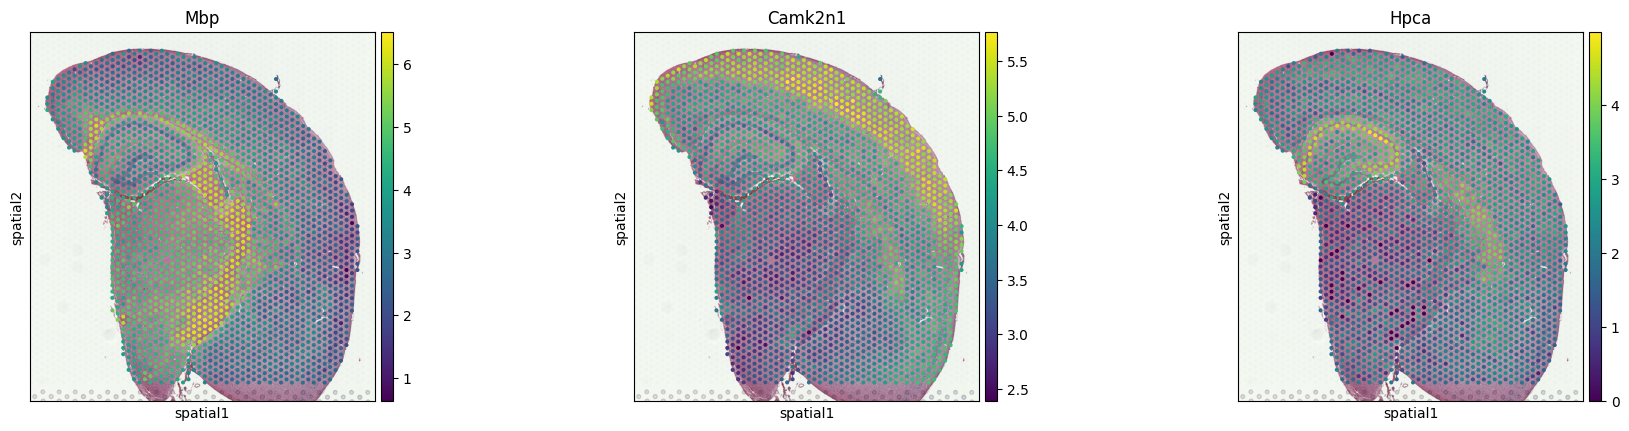

In [84]:
sc.pl.spatial(adata, color = ["Mbp", "Camk2n1", "Hpca"], gene_symbols="gene_symbol")

In [85]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="clusters")

         Falling back to preprocessing with `sc.pp.pca` and default params.


/opt/miniconda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/opt/miniconda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


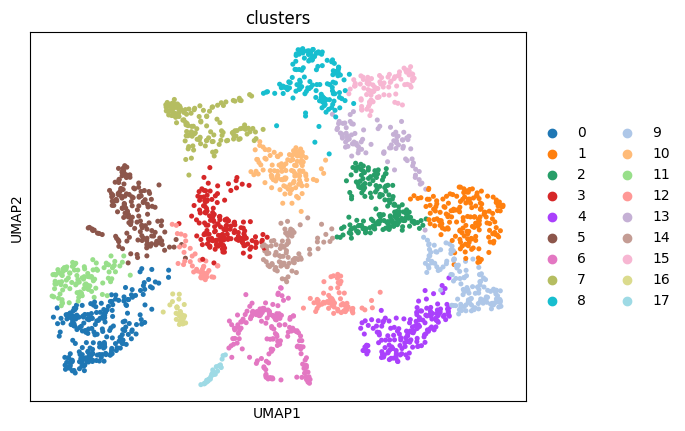

In [87]:
sc.pl.umap(
    adata, color=["clusters"], palette=sc.pl.palettes.default_20
)

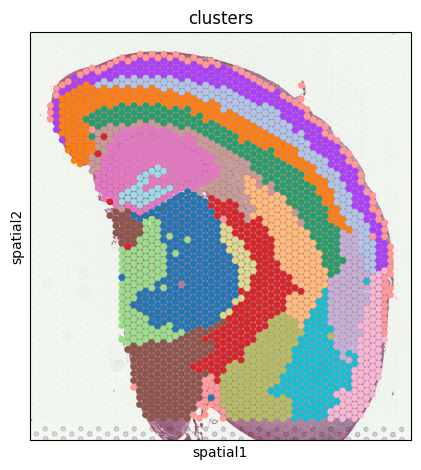

In [88]:
clusters_colors = dict(
    zip([str(i) for i in range(len(adata.obs.clusters.cat.categories))], adata.uns["clusters_colors"])
)
    
ad = adata.copy()
sc.pl.spatial(
    ad,
    img_key="hires",
    color="clusters",
    size=1.5,
    palette=[
        v
        for k, v in clusters_colors.items()
        if k in ad.obs.clusters.unique().tolist()
    ],
    legend_loc=None,
    show=False,
)

plt.tight_layout()